In [336]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

In [337]:
def data_reading(filename):
    train_data = pd.read_csv (filename, delimiter=",")
    test_data = pd.read_csv ("heart_simplified_test.csv", delimiter=",")
    data_numerical = train_data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']].values
    data_combined = train_data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Sex', 'ChestPainType']].values
    data_labels = train_data[['HeartDisease']].values


    print("Number of samples: %i" % data_numerical.shape[0])
    print("Number of numerical features: %i" % data_numerical.shape[1])
    print("Number of combined features: %i" % data_combined.shape[1])

    return data_numerical, data_combined, data_labels

In [338]:
train_data_numerical, train_data_combined, train_data_labels = data_reading("heart_simplified_train.csv")
validation_data_numerical, validation_data_combined, validation_data_labels = data_reading("heart_simplified_validation.csv")
test_data_numerical, test_data_combined, test_data_labels = data_reading("heart_simplified_test.csv")

Number of samples: 500
Number of numerical features: 4
Number of combined features: 6
Number of samples: 100
Number of numerical features: 4
Number of combined features: 6
Number of samples: 100
Number of numerical features: 4
Number of combined features: 6


In [339]:
class NearestNeighborRegressor:
    
    def __init__(self, n_neighbors = 3, weights = [1,1], distance_metric = 'numerical'):
        """ 
       Initializes the model.

        Parameters
        ----------
        n_neighbors : The number of nearest neigbhors (default 1)
        weights : Weighting factors for numerical and categorical features
        distance_metric : The distance metric to use for predictions
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.distance_metric = distance_metric

    
    def fit(self, X, t, type):
        """
        Fits the nearest neighbor regression model.
        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        t : Array of labels [n_samples]
        type: feature types'numerical' or 'combined' 
     
        """ 
       
        # Reshape both arrays to make sure that we deal with 
        # N-dimensional Numpy arrays
        self.X = np.array(X).reshape((len(X), -1))
        self.t = np.array(t).reshape((-1, 1))

        # Create lists of strings for numerical and categorical features
        self.features = type
        self.numerical_features = [i for i in range(X.shape[1]) if self.features[i] == "numerical"]
        self.categorical_features = [i for i in range(X.shape[1]) if self.features[i] != "numerical"]
    

    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        predictions : array-like of length n_samples
        """ 
        predictions = []
        for x in X:
            distances = []
            for i, point in enumerate(self.X):
                if self.distance_metric == 'mixed_distance':
                    distance = self.__mixedDistance(x, point, self.weights[0], self.weights[1])
                else:
                    distance = self.__numericalDistance(x, point)
                distances.append((distance, i))
            # sort the distances in ascending order
            distances = sorted(distances, key=lambda x: x[0])
            # make list of indices corresponding to the closest self.n_neighbors data points. 
            label_indices = [x[1] for x in distances[:self.n_neighbors]]
            #This code creates a list called "labels" which contains the 
            # elements from the list "self.t" at the indexes specified in the list "label_indx".
            #It is likely that "self.t" is a list of labels for the data points in the dataset,
            #  and "label_indx" is a list of indices corresponding to the closest "self.n_neighbors"
            #  data points. Therefore, the code is extracting the labels of the closest data points 
            # and creating a list of those labels. This is probably used to classify the given point
            #  based on the majority label among its nearest neighbours.
            
            labels = [self.t[i] for i in label_indices]
            predictions.append(np.mean(labels))
        return predictions
        


    def __numericalDistance(self, p, q):
        """
        Computes the Euclidean distance between 
        two points.
        """
        distance = math.sqrt(np.sum((q - p) ** 2))
        return distance


    
    def __mixedDistance(self, p, q, numerical_weight, categorical_weight):
        """
        Computes the distance between 
        two points via the pre-defined matrix.
        """
        distance = 0
        # distance for numerical features
        for value in self.numerical_features:       
            if isinstance(p[value], (int, float)):
                distance += numerical_weight * (p[value] - q[value]) ** 2   
        # distance for categorical features
        for value in self.categorical_features:     
            if p[value] != q[value]:
                distance += categorical_weight
        return distance
    
    
    def rmse(self, t, tp):
        """ Computes the RMSE for two
        input arrays 't' and 'tp'.
        """
        n = len(t)
        error = (t - tp)**2
        rmse = math.sqrt(np.sum(error)/n)
        return rmse


    def accuracy(self, t, tp):
        """ Computes the RMSE for two
        input arrays 't' and 'tp'.
        """   
        n_correct = 0
        for i in range(len(t)):
            if np.round(t[i]) == np.round(tp[i]):
                n_correct += 1
        accuracy = n_correct/len(t)
        return accuracy


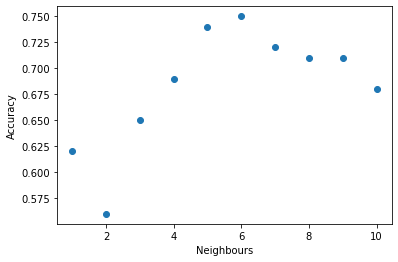

Optimal neighbours: 6
RMSE for optimal neighbours: 5.099020
Accuracy for optimal neighbours: 0.750000


In [340]:

kNN = NearestNeighborRegressor(distance_metric = 'numerical')
type = ['numerical'] * 4
# fit the model using the training data
kNN.fit(train_data_numerical, train_data_labels, type)  

rmses = []
accuracies = []
for n_neighbours in range(1, 11):
    kNN.n_neighbors = n_neighbours
    predictions = kNN.predict(test_data_numerical)
    rmse = kNN.rmse(test_data_labels, predictions)
    rmses.append(rmse)
    accuracy = kNN.accuracy(test_data_labels, predictions)
    accuracies.append(accuracy)

plt.scatter(range(1, 11), accuracies)
plt.xlabel("Neighbours")
plt.ylabel("Accuracy")
plt.show()

# Find the optimal number of neighbours and shift one to 
# the right to fit into range(1, 11)
optimal_neighbours = np.argmax(accuracies) + 1
print("Optimal neighbours: %d" % optimal_neighbours)
print("RMSE for optimal neighbours: %f" % rmses[optimal_neighbours - 1])
print("Accuracy for optimal neighbours: %f" % accuracies[optimal_neighbours - 1])

In [341]:
# Initialize weights for categorical features to balance the combined distance
w_cat_factors = [0.01, 0.025, 0.05, 0.1]
type = ['numerical'] * 4 + ['categorical'] * 2
k = 5

for w in w_cat_factors:
    # Initialize kNN model with weight = 1 for numerical categories and 
    # w_cat_factors for categorical categories and 'mixed_distance' for
    # computing combined distances
    kNN = NearestNeighborRegressor(k,  weights = [1, w], distance_metric = 'mixed_distance')
    kNN.fit(train_data_combined, train_data_labels, type)
    predictions = kNN.predict(test_data_combined)
    rmse = kNN.rmse(test_data_labels, predictions)
    accuracy = kNN.accuracy(test_data_labels, predictions)
    print("w_cat_factor:", w, " RMSE:", rmse, " Accuracy:", accuracy)

w_cat_factor: 0.01  RMSE: 5.057667446560717  Accuracy: 0.77
w_cat_factor: 0.025  RMSE: 5.1536394906900505  Accuracy: 0.77
w_cat_factor: 0.05  RMSE: 5.203844732503075  Accuracy: 0.75
w_cat_factor: 0.1  RMSE: 5.238320341483519  Accuracy: 0.74
